# Predictive Maintenance

Dataset taken from

http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv

PROJECT: Maintenance cost reduction through predictive techniques

BACKGROUND
A company has a fleet of devices transmitting daily telemetry readings. They would like to create a predictive
maintenance solution to proactively identify when maintenance should be performed. This approach promises cost
savings over routine or time-based preventive maintenance, because tasks are performed only when warranted.

GOAL
You are tasked with building a predictive model using machine learning to predict the probability of a device failure.
When building this model, be sure to minimize false positives and false negatives. The column you are trying to predict is called failure with binary value 0 for non-failure and 1 for failure.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the Dataset

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.models  import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv2D, MaxPooling2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

%matplotlib inline
print('Done !!!')

Done !!!


In [6]:
# Read the dataset 
from pathlib import Path
file_dir = Path('/content/drive/My Drive/Data_Science/projects/predictive_maintenance/data')

df = pd.read_csv( file_dir / 'predictive_maintenance.csv',
                 parse_dates = True, index_col = 'date',
                 delimiter = ',')


In [7]:
df.head()

,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
date,,,,,,,,,,,
2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [8]:
df.tail()

,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
date,,,,,,,,,,,
2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0
2015-11-02,Z1F0QLC1,0,17572840,0,0,0,10,351431,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124494 entries, 2015-01-01 to 2015-11-02
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   device   124494 non-null  object
 1   failure  124494 non-null  int64 
 2   metric1  124494 non-null  int64 
 3   metric2  124494 non-null  int64 
 4   metric3  124494 non-null  int64 
 5   metric4  124494 non-null  int64 
 6   metric5  124494 non-null  int64 
 7   metric6  124494 non-null  int64 
 8   metric7  124494 non-null  int64 
 9   metric8  124494 non-null  int64 
 10  metric9  124494 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 11.4+ MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
failure,124494.0,8.514467e-04,2.916725e-02,0.0,0.0,0.0,0.0,1.0
metric1,124494.0,1.223881e+08,7.045933e+07,0.0,61284762.0,122797388.0,183309640.0,244140480.0
metric2,124494.0,1.594848e+02,2.179658e+03,0.0,0.0,0.0,0.0,64968.0
metric3,124494.0,9.940455e+00,1.857473e+02,0.0,0.0,0.0,0.0,24929.0
metric4,124494.0,1.741120e+00,2.290851e+01,0.0,0.0,0.0,0.0,1666.0
metric5,124494.0,1.422267e+01,1.594303e+01,1.0,8.0,10.0,12.0,98.0
metric6,124494.0,2.601727e+05,9.915108e+04,8.0,221452.0,249799.5,310266.0,689161.0
metric7,124494.0,2.925282e-01,7.436924e+00,0.0,0.0,0.0,0.0,832.0
metric8,124494.0,2.925282e-01,7.436924e+00,0.0,0.0,0.0,0.0,832.0
metric9,124494.0,1.245152e+01,1.914256e+02,0.0,0.0,0.0,0.0,18701.0


In [ ]:
df.shape

(124494, 11)

# Data Cleaning

In [10]:
df.isnull().sum()

device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [11]:
# There are no NaN in any column

In [12]:
df.describe()


,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


In [13]:
#### it looks like mteric7 and metic8 are identical. 
#There should be harm indropping metric8
df.drop('metric8', axis =1 , inplace = True)

In [14]:
df.head()

,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9
date,,,,,,,,,,
2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7
2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0
2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0
2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0
2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3


In [15]:
# since device an object column, it makes more sense to convert into one hot encodig
# Apply one hot encoding for device column
df_dev = pd.get_dummies(df.device, prefix = 'dev_')

In [16]:
df_dev.shape

(124494, 1169)

In [17]:
# conctenate both dfs and remove device column

df_one_hot = pd.concat([df, df_dev], axis =1) 
df_one_hot.drop(['device'], axis = 1, inplace = True)


In [18]:
df_one_hot.shape

(124494, 1178)

In [19]:
df_one_hot.head(10)

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,dev__S1F01085,dev__S1F013BB,dev__S1F0166B,dev__S1F01E6Y,dev__S1F01JE0,dev__S1F01R2B,dev__S1F01TD5,dev__S1F01XDJ,dev__S1F023H2,dev__S1F02A0J,dev__S1F02DZ2,dev__S1F02EVN,dev__S1F02L38,dev__S1F02MGA,dev__S1F02P76,dev__S1F02VAX,dev__S1F02W1L,dev__S1F02WFT,dev__S1F02XLX,dev__S1F0318A,dev__S1F0322R,dev__S1F0330P,dev__S1F03499,dev__S1F035SJ,dev__S1F0377V,dev__S1F039FE,dev__S1F03RV3,dev__S1F03YZM,dev__S1F044ET,dev__S1F049RX,dev__S1F04DH8,...,dev__Z1F18YST,dev__Z1F1901P,dev__Z1F19ENW,dev__Z1F19KMH,dev__Z1F19QH0,dev__Z1F19QM3,dev__Z1F19TP2,dev__Z1F19TVX,dev__Z1F19VF5,dev__Z1F1A0CJ,dev__Z1F1A0LM,dev__Z1F1A0RP,dev__Z1F1A1HH,dev__Z1F1A7MG,dev__Z1F1A83K,dev__Z1F1AD0M,dev__Z1F1AF54,dev__Z1F1AFF2,dev__Z1F1AFT5,dev__Z1F1AG5N,dev__Z1F1AGLA,dev__Z1F1AGN5,dev__Z1F1AGW1,dev__Z1F1B6H4,dev__Z1F1B6NP,dev__Z1F1B799,dev__Z1F1CZ35,dev__Z1F1FCH5,dev__Z1F1FZ9J,dev__Z1F1HEQR,dev__Z1F1HSWK,dev__Z1F1Q9BD,dev__Z1F1R76A,dev__Z1F1RE71,dev__Z1F1RJFA,dev__Z1F1VMZB,dev__Z1F1VQFY,dev__Z1F26YZB,dev__Z1F282ZV,dev__Z1F2PBHX
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,215630672,56,0,52,6,407438,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,61370680,0,3,0,6,403174,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,173295968,0,0,0,12,237394,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,79694024,0,0,0,6,410186,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,135970480,0,0,0,15,313173,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,68837488,0,0,41,6,413535,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,227721632,0,0,0,8,402525,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,141503600,0,0,1,19,494462,16,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-01-01,0,8217840,0,1,0,14,311869,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
df_one_hot.columns

Index(['failure', 'metric1', 'metric2', 'metric3', 'metric4', 'metric5',
       'metric6', 'metric7', 'metric9', 'dev__S1F01085',
       ...
       'dev__Z1F1HSWK', 'dev__Z1F1Q9BD', 'dev__Z1F1R76A', 'dev__Z1F1RE71',
       'dev__Z1F1RJFA', 'dev__Z1F1VMZB', 'dev__Z1F1VQFY', 'dev__Z1F26YZB',
       'dev__Z1F282ZV', 'dev__Z1F2PBHX'],
      dtype='object', length=1178)

# EDA

In [20]:
df_one_hot['failure'].value_counts()

0    124388
1       106
Name: failure, dtype: int64

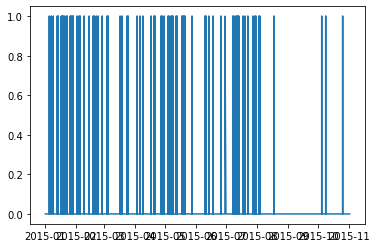

In [25]:
# df_one_hot.plot.scatter(x = 'date', y= 'failure')

plt.plot(df_one_hot.index, df_one_hot.failure)

In [ ]:
failurePercentage = 100 * df_one_hot['failure'].sum() / df.shape[0]
print('Total num of failures {} out of {}'.format(df_one_hot['failure'].sum(), df.shape[0]))
print('Percentage of failures = {0:.2f} %'.format(failurePercentage))

Total num of failures 106 out of 124494
Percentage of failures = 0.09 %


In [ ]:
(df_one_hot == 0).sum() # checking how many zeros are there in each column

failure          124388
metric1              11
metric2          118110
metric3          115359
metric4          115156
                  ...  
dev__Z1F1VMZB    124202
dev__Z1F1VQFY    124369
dev__Z1F26YZB    124410
dev__Z1F282ZV    124410
dev__Z1F2PBHX    124411
Length: 1178, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Failure Distributions \n (0: No Failure || 1: Failure)')

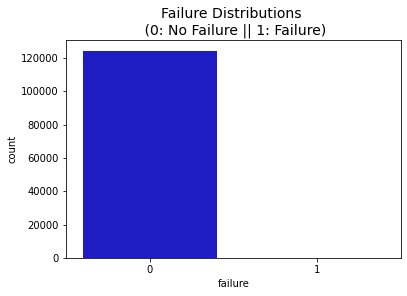

In [ ]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('failure', data=df_one_hot, palette=colors)
plt.title('Failure Distributions \n (0: No Failure || 1: Failure)', fontsize=14)

In [ ]:
df_one_hot.columns

Index(['failure', 'metric1', 'metric2', 'metric3', 'metric4', 'metric5',
       'metric6', 'metric7', 'metric9', 'dev__S1F01085',
       ...
       'dev__Z1F1HSWK', 'dev__Z1F1Q9BD', 'dev__Z1F1R76A', 'dev__Z1F1RE71',
       'dev__Z1F1RJFA', 'dev__Z1F1VMZB', 'dev__Z1F1VQFY', 'dev__Z1F26YZB',
       'dev__Z1F282ZV', 'dev__Z1F2PBHX'],
      dtype='object', length=1178)

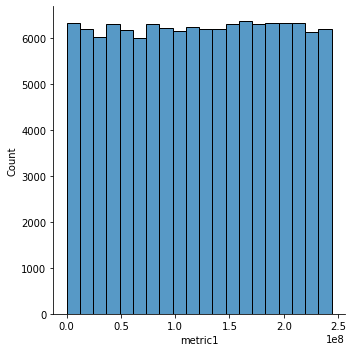

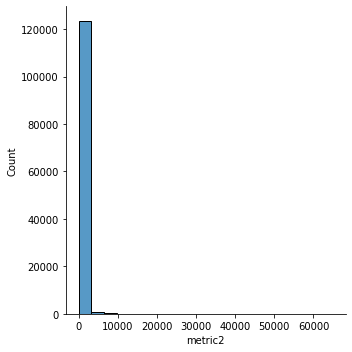

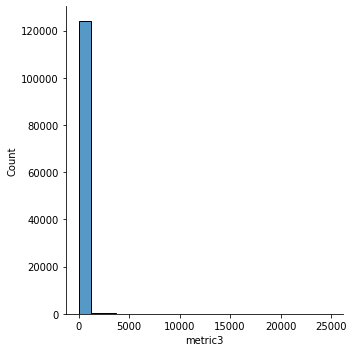

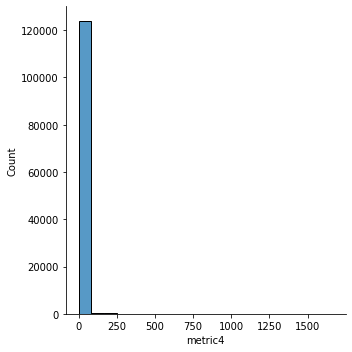

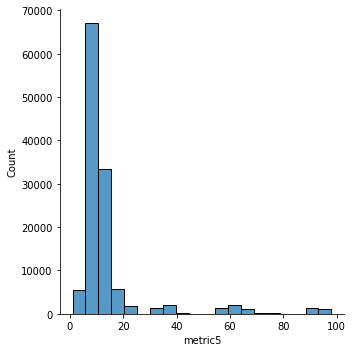

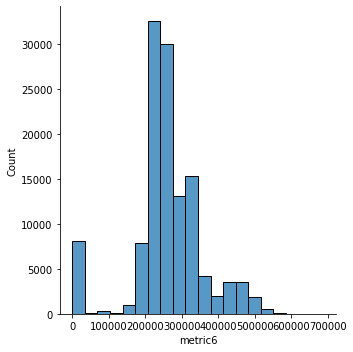

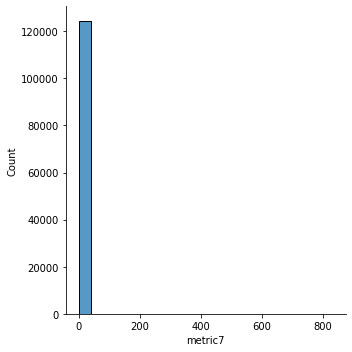

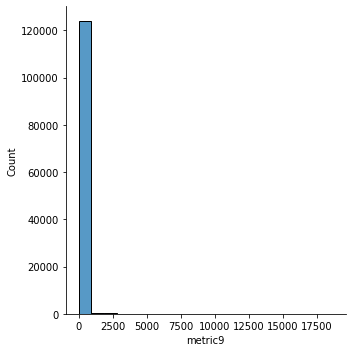

In [ ]:
col_name= ['metric1', 'metric2', 'metric3', 'metric4', 'metric5',
       'metric6', 'metric7', 'metric9']
for c in col_name:
  sns.displot(df_one_hot, x = c, bins=20 )

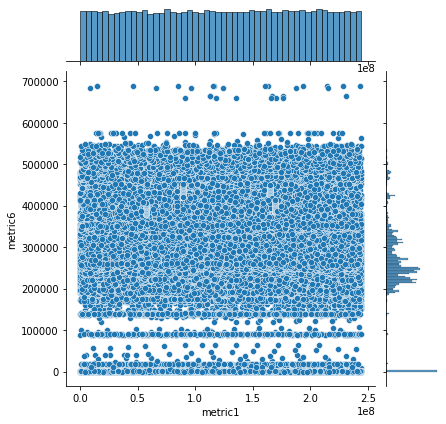

In [ ]:
sns.jointplot(data = df_one_hot, x = 'metric1', y= 'metric6')

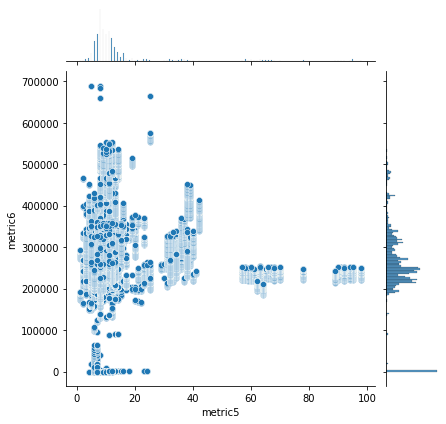

In [ ]:
sns.jointplot(data = df_one_hot, x = 'metric5', y= 'metric6')

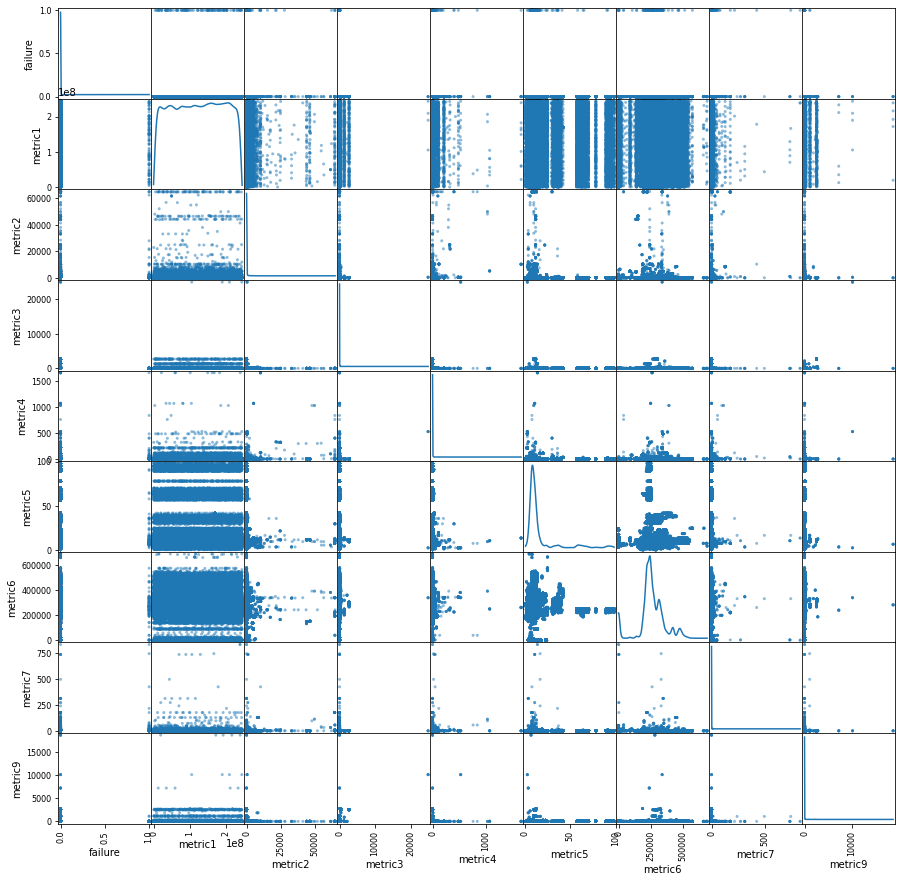

In [ ]:
scatter_matrix = scatter_matrix(df, figsize = (15,15),diagonal = 'kde' )


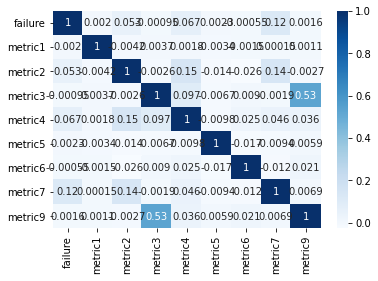

In [ ]:
sns.heatmap(df.corr(), annot = True, cmap = 'Blues')


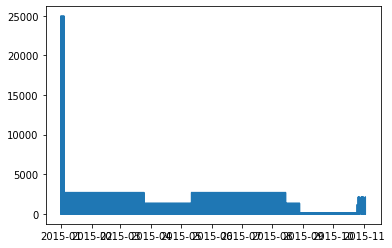

In [ ]:
plt.plot(df_one_hot['metric3'])


In [ ]:
# save the df_one_hot file for future

df_one_hot.to_csv(file_dir / 'df_one_hot.csv', sep = ',')
print('Done')

Done
